# 1. 사진 준비하기
- OpenCV로 이미지를 읽어와서 resize하고 RGB 이미지로 바꾸어 출력한다.

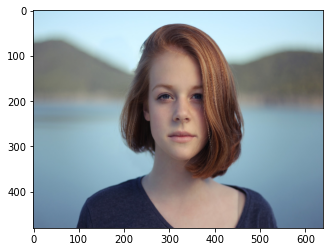

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image.jpg'
img_bgr = cv2.imread(my_image_path)  # OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (640, 480))    # Resize
img_show = img_bgr.copy()      # 출력용 이미지 별도 카피
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)  # RGB 이미지로 변경
plt.imshow(img_rgb)
plt.show()

- **cv2.imread('img.png', flag)**: 이미지를 읽을 때 flag를 설정할 수 있다. 다음 순서대로 1, 0, -1의 값을 가지며 default는 0이다.
    - cv2.IMREAD_COLOR: 이미지 파일을 Color로 읽어들이기, 투명한 부분은 무시
    - cv2.IMREAD_GRAYSCALE: 이미지를 Grayscale로 읽어들이기, 실제 이미지 처리시 중간단계로 많이 사용
    - cv2.IMREAD_UNCHANGED: 이미지파일을 alpha channel까지 포함하여 읽어들임
- **cv2.resize(img, size)**: 원본 이미지 비율에 맞게 축소(640x360 (16:9), 640x480 (4:3))
- **cv2.cvtColor(img, cv2.COLOR_BGR2RGB)**: opencv는 예외적으로 RGB가 아닌 BGR(파랑, 녹색, 빨강)를 사용한다. 그래서 원본 사진을 불러오면 붉은색은 푸른색으로, 푸른색은 붉은색으로 바뀌어 출력된다. opencv에서 다룬 이미지를 다른 이미지 라이브러리를 활용하여 출력하려면 RGB 이미지로 바꿔야 한다.

***
# 2. Face Detection

- dlib의 face detector는 **HOG**(Histogram of Oriented Gradient) feature를 사용해서 SVM(Support Vector Machine)의 sliding window로 얼굴을 찾는다.
    - 그래디언트(gradient)를 특징(feature)으로 사용: 동일한 오브젝트라도 밝을 때와 어두울 때의 픽셀값의 분포는 완전히 다르다. 따라서 픽셀의 RGB값 자체보다는 밝기가 변하는 방향(그래디언트)을 고려하면 주변 상황과 무관하게 동일한 표현(representation)을 얻을 수 있다.
    - 단일 픽셀의 그래디언트가 아닌 16x16 의 정사각형을 사용: 이미지의 기본 패턴을 알려면 단일 픽셀보다는 높은 수준에서 명암의 기본 흐름을 보는 것이 더 좋다.

rectangles[[(242, 139) (428, 325)]]


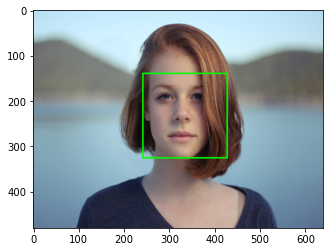

In [2]:
import dlib
detector_hog = dlib.get_frontal_face_detector()   # dlib을 활용해 hog detector를 선언
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)  # dlib은 rgb 이미지를 입력으로 받음
dlib_rects = detector_hog(img_rgb, 1)   # detector를 이용해서 얼굴의 bounding box를 추출

print(dlib_rects)   # 얼굴 영역 좌표 출력

# 이미지 위에 얼굴의 bounding box 출력
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

- **detector_hog(img, num of img pyramid)**: 
    - 동일 이미지의 서로 다른 사이즈의 set을 이미지 피라미드라고 한다. 이미지를 upsampling 방법을 통해 크기를 키우고 얼굴을 다시 검출하면 작게 촬영된 얼굴을 크게 볼 수 있기 때문에 더 정확한 검출이 가능하다.
    - dlib detector는 dlib.rectangles 타입의 객체를 반환하고, dlib.rectangles는 dlib.rectangle 객체의 배열 형태로 이루어져 있다. lib.rectangle 객체는 left(), top(), right(), bottom(), height(), width() 등의 멤버 함수를 포함하고 있다.

***
# 3. Face Landmark

- **Face landmark localization**: detection의 결과물인 bounding box로 잘라낸(crop) 얼굴 이미지에서 이목구비의 위치를 찾아내는 기술
- **Object keypoint estimation**: Face landmark와 같이 객체 내부의 점을 찾는 기술(본 예제에서는 1번 방식을 다룸)
    - top-down : bounding box를 찾고 box 내부의 keypoint를 예측
    - bottom-up : 이미지 전체의 keypoint를 먼저 찾고 point 관계를 이용해 군집화 해서 box 생성

- **Dlib landmark localization**: Dlib에서 제공하는 ibug 300-W 데이터셋으로 학습한 pretrained model 사용하며, 잘라진 얼굴 이미지에서 68개의 이목구비 위치를 찾아냄

In [3]:
# landmark 모델을 불러오기
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

# landmark 개별 위치 저장
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))   # 68개의 (x,y) 튜플로 이루어진 리스트

68


- **landmark_predictor**: RGB 이미지와 dlib.rectangle을 입력 받아 dlib.full_object_detection를 반환함
- **points**: dlib.full_object_detection의 객체이므로 parts() 함수로 개별 위치에 접근 가능(lambda 함수를 사용해 조금 더 직관적인 (x, y) 형태로 접근할 수 있도록 변환)
- **list_points**: tuple (x, y) 68개로 이루어진 리스트로, 이미지에서 찾아진 얼굴 개수마다 반복하면 list_landmark에 68개의 랜드마크가 얼굴 개수만큼 저장됨

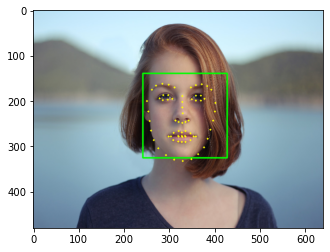

In [4]:
# 이미지에 landmark 출력
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

***
# 4. 스티커 적용하기

- 랜드마크를 기준으로 스티커를 붙일 위치와 스티커의 크기를 계산한다.
- 얼굴 위치, 카메라의 거리에 따라 픽셀 x가 다르기 때문에 비율로 계산을 해줘야 한다.

## 4-1. 스티커 위치 및 크기 계산

In [5]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # 코의 중심점 좌표 확인(nose center index: 30)
    x = landmark[30][0]
    y = landmark[30][1] - dlib_rect.width()//2
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))  # 스티커의 위치 (x,y)
    print ('(w,h) : (%d,%d)'%(w,h))  # 스티커의 크기 (w,h)

(330, 227)
(x,y) : (330,134)
(w,h) : (187,187)


## 4-2. 스티커 resize & 좌표 조정

In [6]:
# 스티커 이미지를 읽어와 윗 단계에서 계산한 크기로 resize
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/king.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

(187, 187, 3)


In [7]:
# 이미지 시작점인 top-left 좌표로 x, y 좌표 변경
refined_x = x - w // 2  # left
refined_y = y - h       # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (237,-53)


In [8]:
# 원본 이미지의 범위를 벗어난 스티커 부분을 제거(-y 크기만큼 스티커를 crop)
img_sticker = img_sticker[-refined_y:]
print (img_sticker.shape)

(134, 187, 3)


In [9]:
# top의 y 좌표는 원본 이미지의 경계 값으로 수정
refined_y = 0
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (237,0)


## 4-3. 스티커 적용

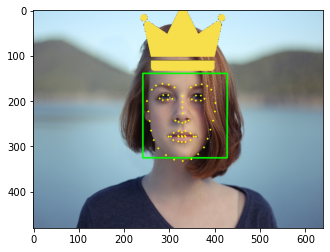

In [10]:
# 원본 이미지에 스티커 적용
sticker_area = img_show[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)

# 결과 이미지 출력
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

- **sticker_area**: 원본 이미지에서 스티커를 적용할 위치를 crop한 이미지로, 예제에서는 (237,0)부터 (237+187, 0+134) 범위의 이미지를 의미
- 스티커 이미지에서 0 이 아닌 색이 있는 부분만 사용한다. **np.where**를 통해 img_sticker가 0인 부분은 sticker_area를 사용하고, 0이 아닌 부분은 img_sticker를 사용한다.

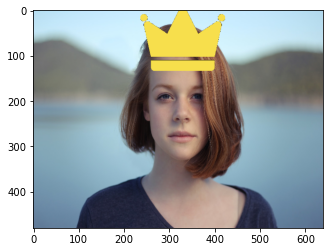

In [11]:
# bounding box와 landmark를 제거하고 최종 결과만 출력
sticker_area = img_bgr[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)

# 결과 이미지 출력
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))  # img_show 대신 아껴 두었던 img_rgb 사용
plt.show()